Problem-1)

Forecast the CocaCola prices data set. Prepare a document for each model explaining

How many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [1]:

#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
cola_sales=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
cola_sales

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


EDA

In [3]:
cola_sales.shape

(42, 2)

In [4]:
cola_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [5]:
cola_sales.nunique()

Quarter    42
Sales      42
dtype: int64

In [6]:
cola_sales.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [7]:
cola_sales.duplicated().value_counts()


False    42
dtype: int64

In [8]:
cola_sales.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [9]:
cola_sales['Quarter_Year'] = cola_sales['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
cola_sales['Date'] = (pd.to_datetime(cola_sales['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
cola_sales['Quarters'] =cola_sales.Quarter.str[:2] 
cola_sales.head()

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1


In [10]:
cola_sales=cola_sales.drop(['Quarter','Quarter_Year'],axis=1)
cola_sales.head()

,Sales,Date,Quarters
0,1734.827000,1986-01-01,Q1
1,2244.960999,1986-04-01,Q2
2,2533.804993,1986-07-01,Q3
3,2154.962997,1986-10-01,Q4
4,1547.818996,1987-01-01,Q1


In [11]:
cola_sales["Date"] = pd.to_datetime(cola_sales.Date,format="%b-%y")
cola_sales["month"] = cola_sales.Date.dt.strftime("%b") # month 
cola_sales["year"] = pd.to_numeric(cola_sales.Date.dt.strftime("%Y")) # year 
cola_sales.set_index('Date',inplace=True)
cola_sales.head()

,Sales,Quarters,month,year
Date,,,,
1986-01-01,1734.827000,Q1,Jan,1986
1986-04-01,2244.960999,Q2,Apr,1986
1986-07-01,2533.804993,Q3,Jul,1986
1986-10-01,2154.962997,Q4,Oct,1986
1987-01-01,1547.818996,Q1,Jan,1987


In [12]:

upsampled_month = cola_sales['Sales']
upsampled_month = upsampled_month.resample('M').mean()
pd.set_option('display.max_rows', 10)
upsampled_month

Date
1986-01-31    1734.827000
1986-02-28            NaN
1986-03-31            NaN
1986-04-30    2244.960999
1986-05-31            NaN
                 ...     
1995-12-31            NaN
1996-01-31    4194.000000
1996-02-29            NaN
1996-03-31            NaN
1996-04-30    5253.000000
Freq: M, Name: Sales, Length: 124, dtype: float64

In [13]:
interpolated_month = upsampled_month.interpolate(method='linear')
interpolated_month=pd.DataFrame(interpolated_month)
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [14]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month 
interpolated_month["year"] =pd.to_numeric( interpolated_month.Date.dt.strftime("%Y")) # year
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola_upsp = pd.concat([interpolated_month,months],axis=1)
cocacola_upsp['log_sales'] = np.log(cocacola_upsp['Sales'])
cocacola_upsp

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


In [15]:

cocacola_upsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       124 non-null    datetime64[ns]
 1   Sales      124 non-null    float64       
 2   t          124 non-null    int32         
 3   t_squared  124 non-null    int32         
 4   month      124 non-null    object        
 5   year       124 non-null    int64         
 6   Jan        124 non-null    uint8         
 7   Feb        124 non-null    uint8         
 8   Mar        124 non-null    uint8         
 9   Apr        124 non-null    uint8         
 10  May        124 non-null    uint8         
 11  Jun        124 non-null    uint8         
 12  Jul        124 non-null    uint8         
 13  Aug        124 non-null    uint8         
 14  Sep        124 non-null    uint8         
 15  Oct        124 non-null    uint8         
 16  Nov        124 non-null    uint8         
 1

VISUALISATION

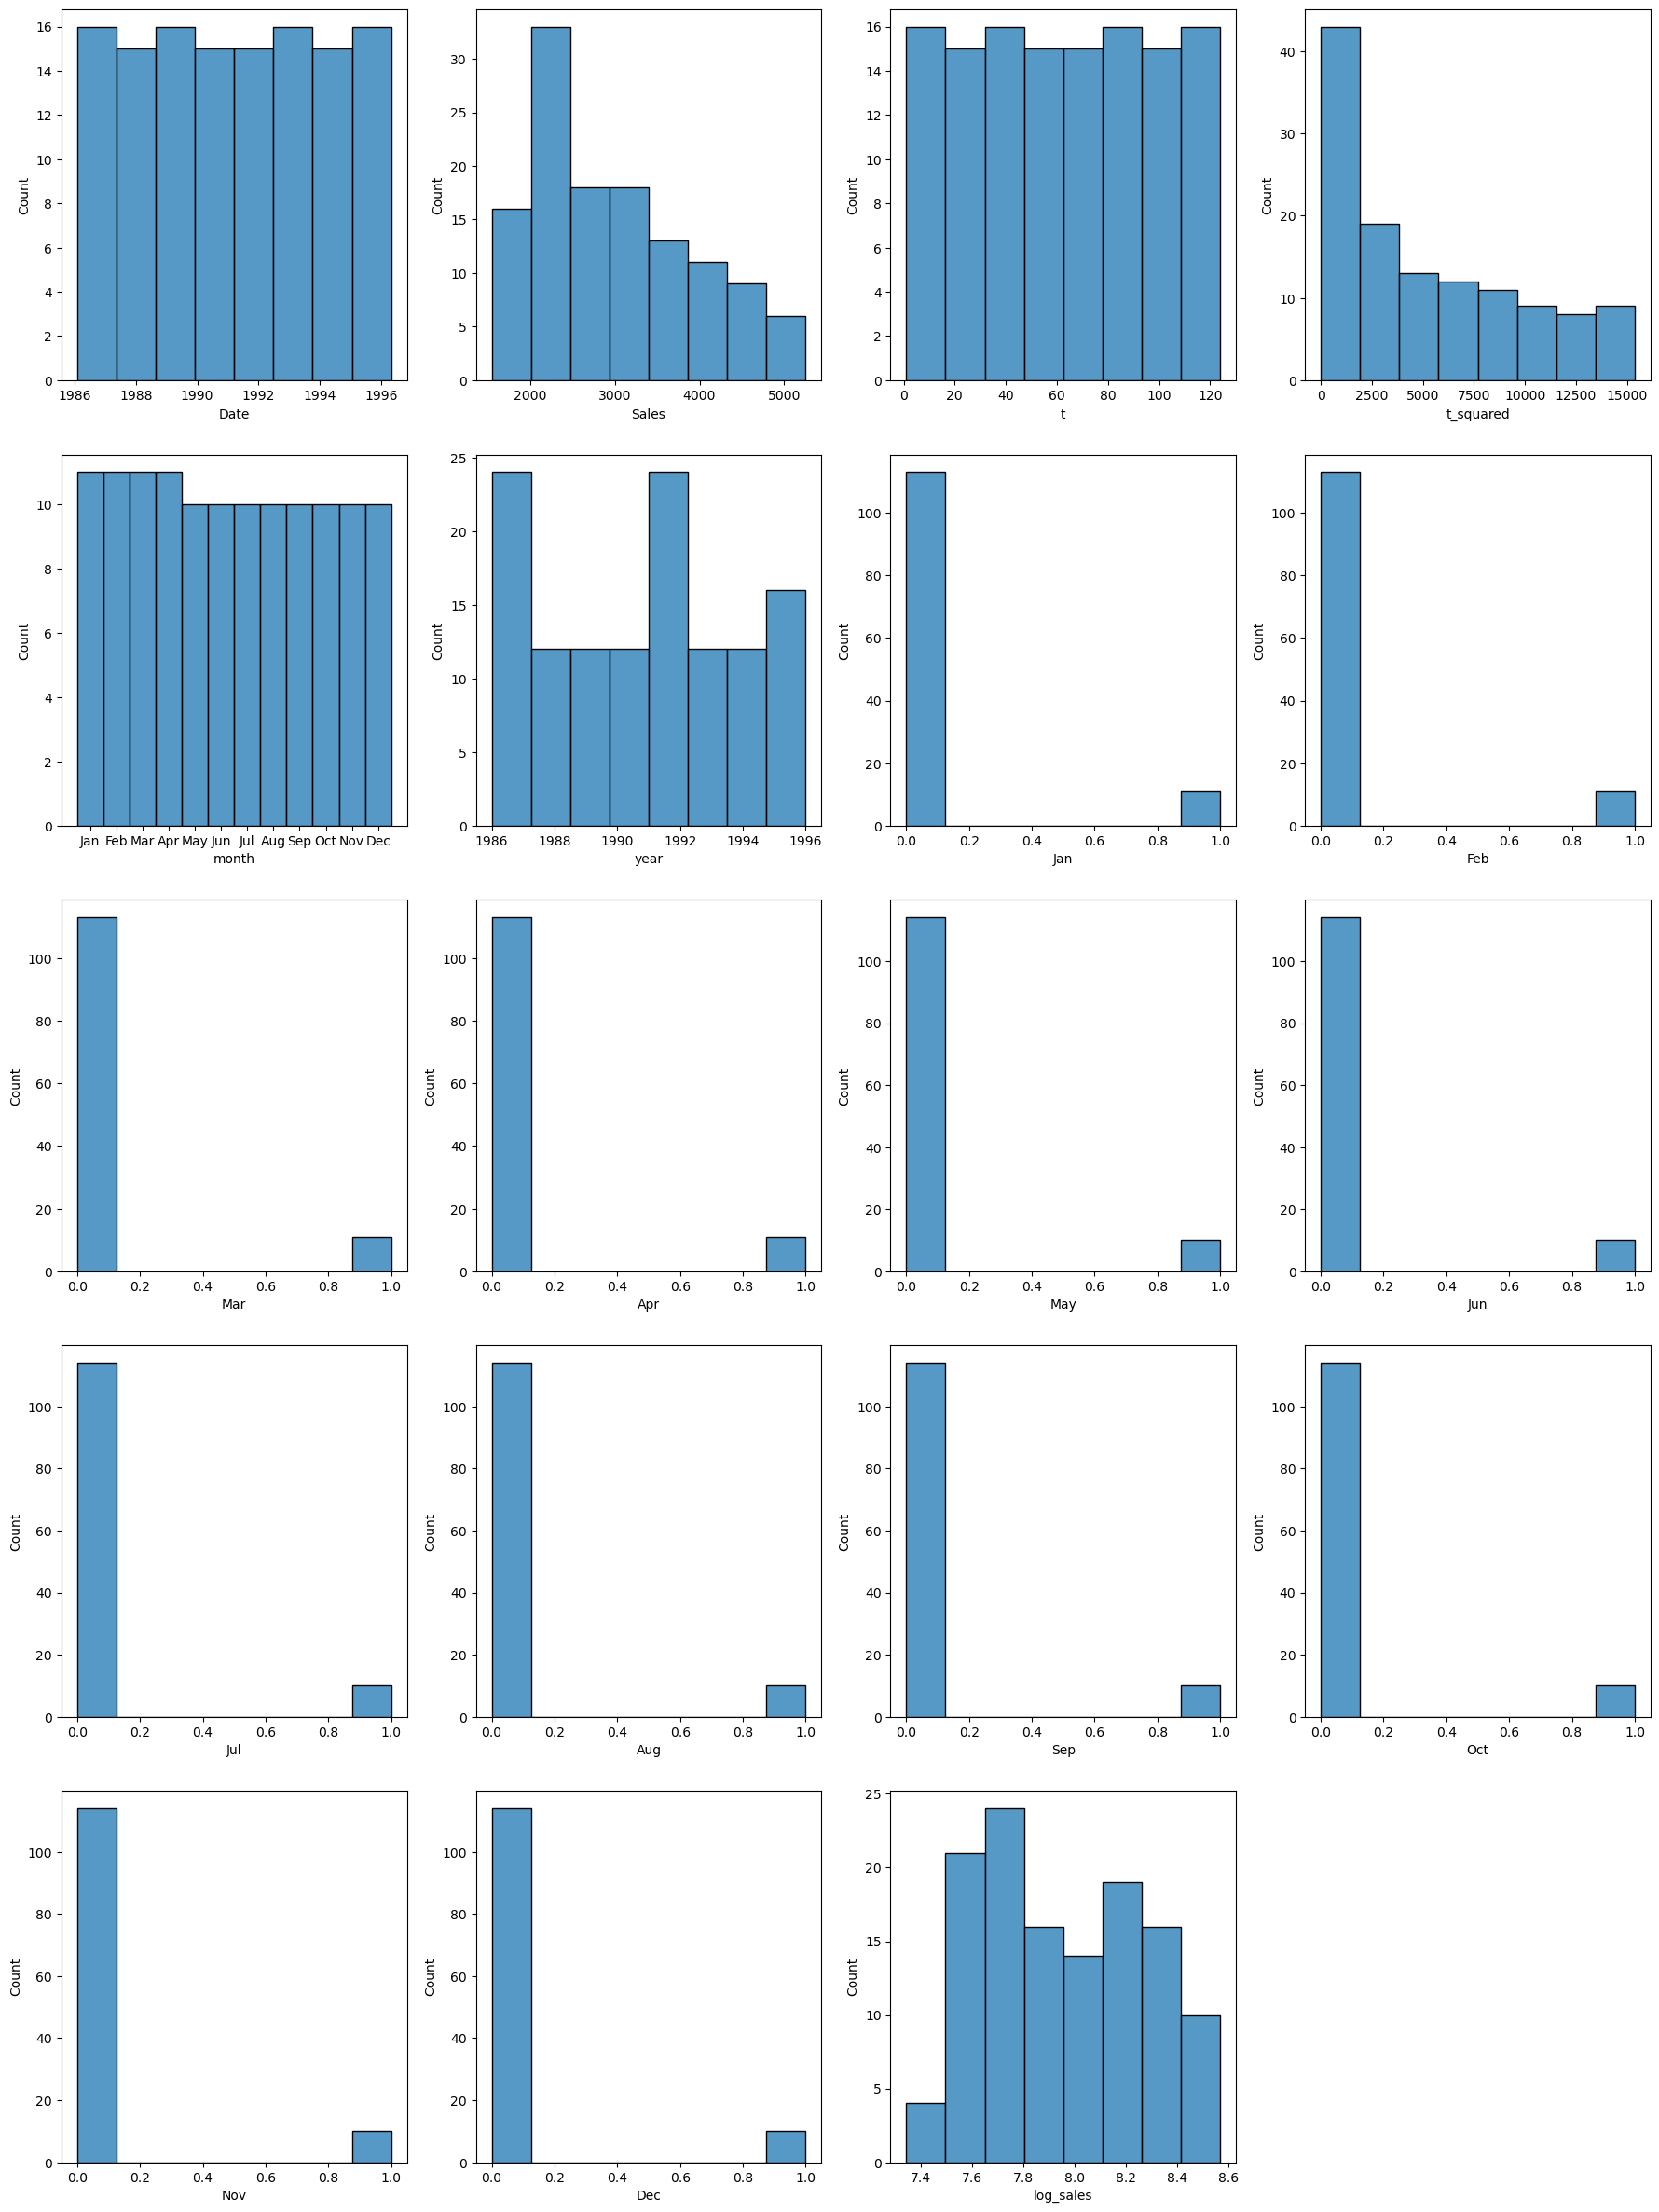

In [16]:
#plotting histplots to observe datapoints nature
plt.figure(figsize=(22,30))
for i, column in enumerate(cocacola_upsp.columns, 1):
    plt.subplot(5,4,i)
    sns.histplot(cocacola_upsp[column])

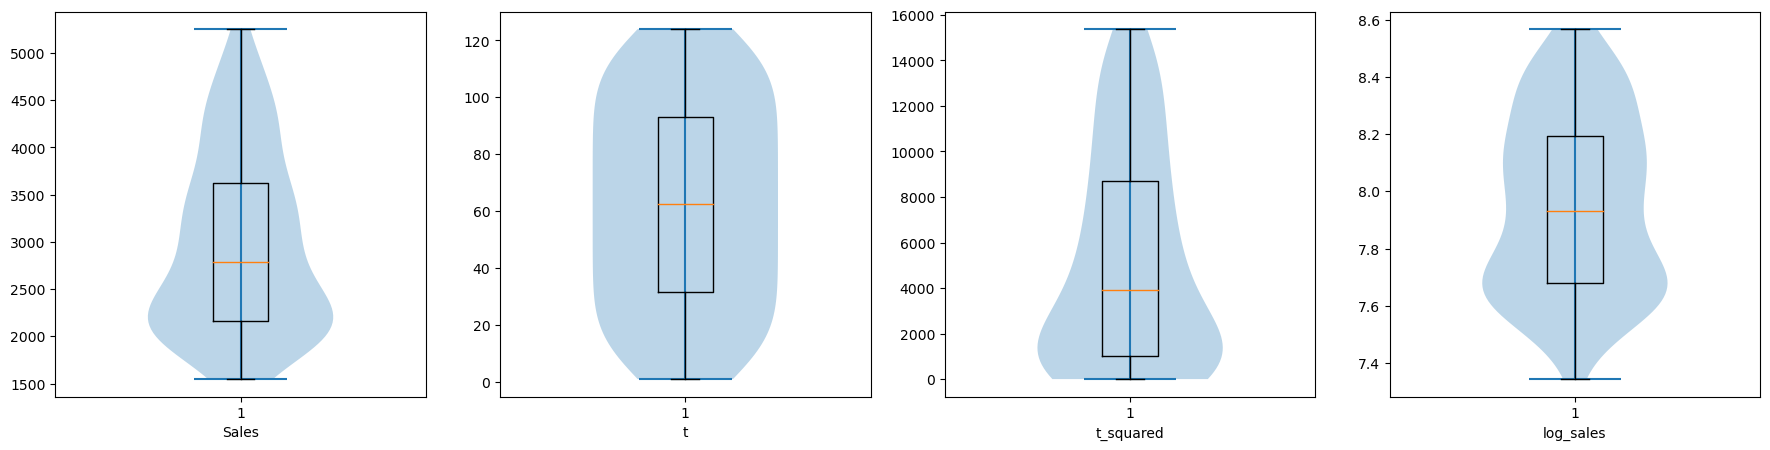

In [17]:
#plotting boxplots to observe datapoints nature
plt.figure(figsize=(22,5))
for i, column in enumerate(['Sales','t','t_squared','log_sales'], 1):
    plt.subplot(1,4,i)
    plt.violinplot(cocacola_upsp[column])
    plt.boxplot(cocacola_upsp[column])
    plt.xlabel(cocacola_upsp[column].name)

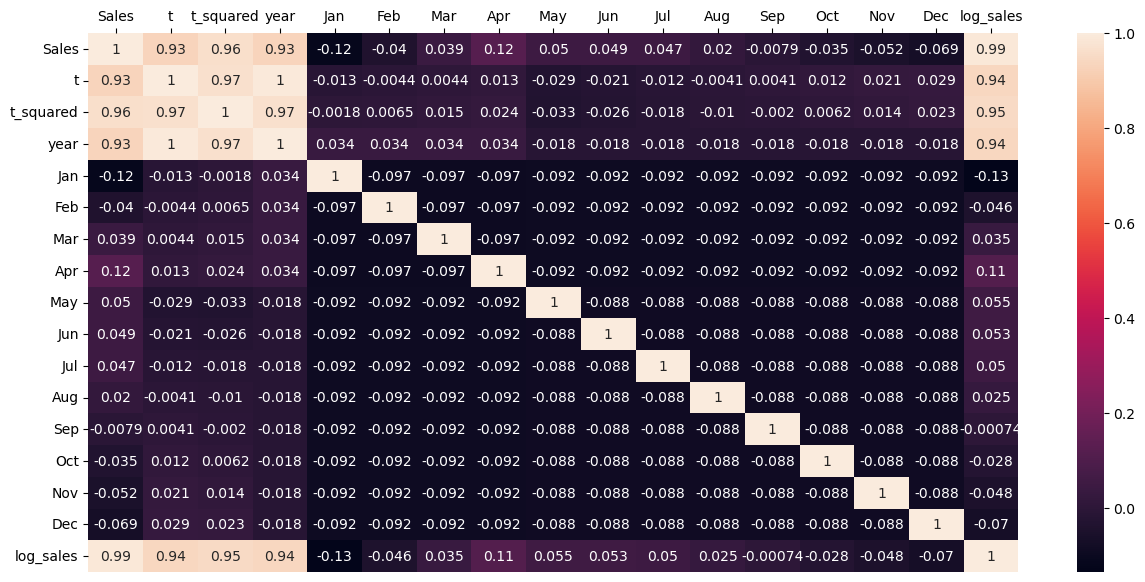

In [18]:
#plotting the heatmap for correlation
plt.figure(figsize=(15,7))
ax = sns.heatmap(cocacola_upsp.corr(), annot=True)
ax.xaxis.tick_top()

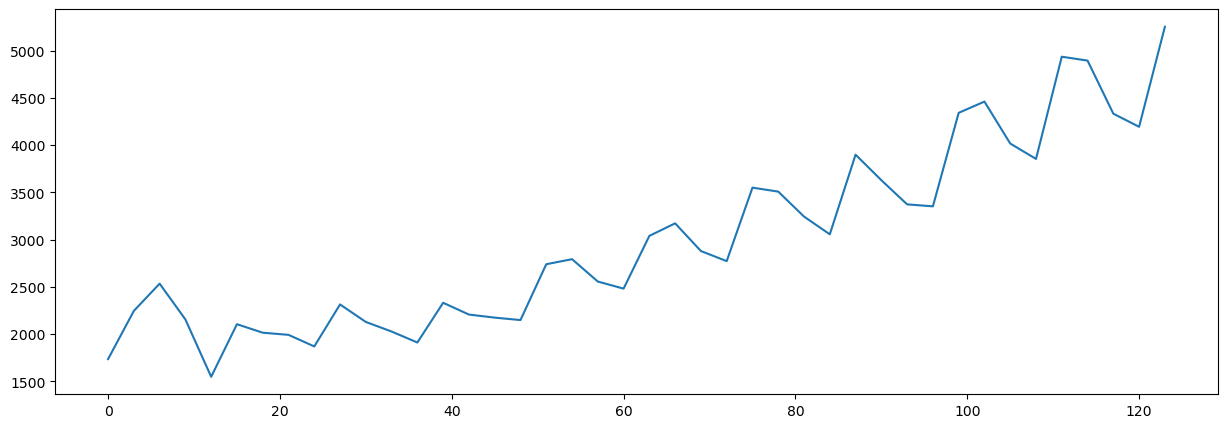

In [19]:
cocacola_upsp['Sales'].plot(figsize=(15, 5))
plt.show()


Moving Average

In [20]:
cocacola_upsp.set_index('Date',inplace=True)
cocacola_upsp.head()

,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
Date,,,,,,,,,,,,,,,,,,
1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437


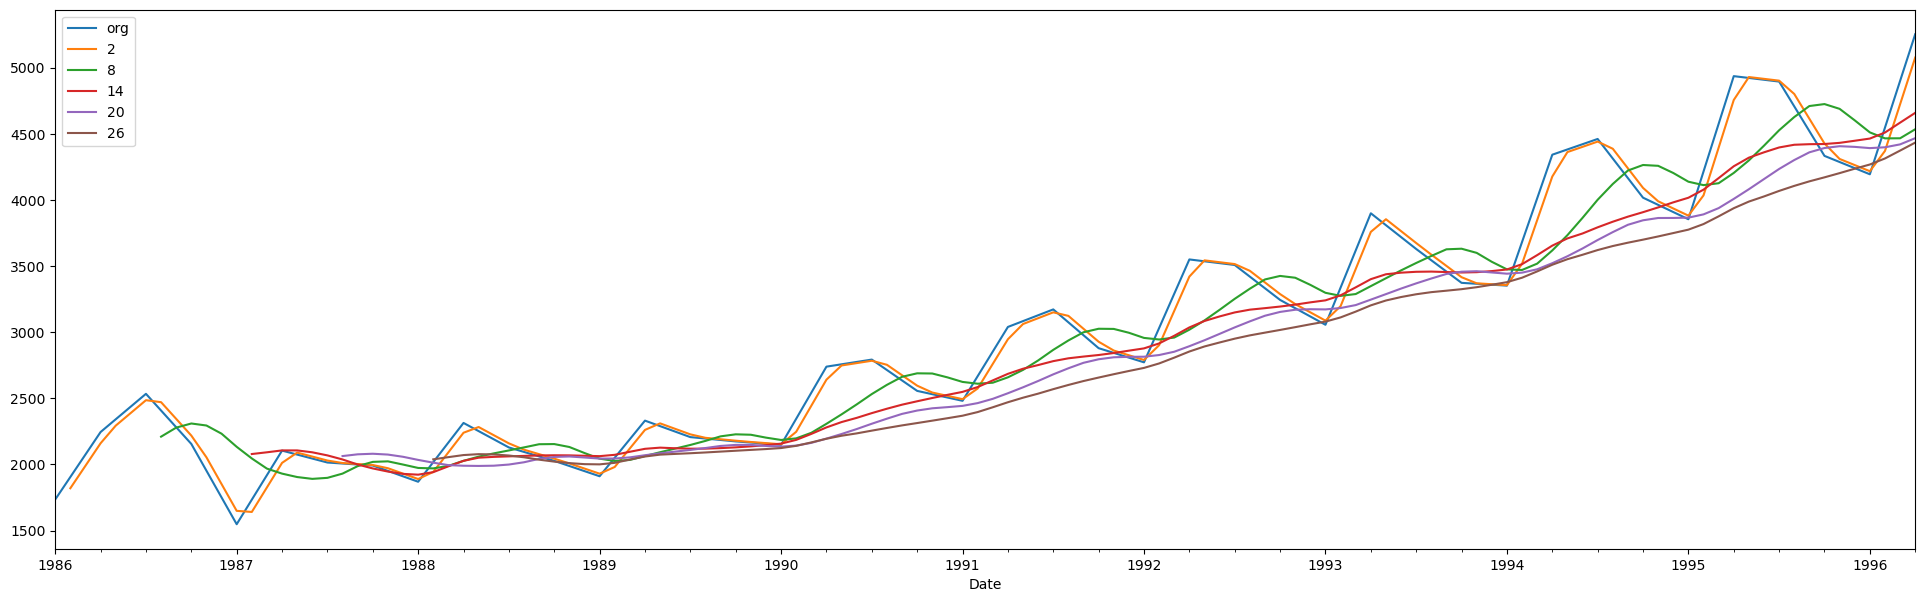

In [21]:
plt.figure(figsize=(24,7))
cola_sales.Sales.plot(label="org")
for i in range(2,30,6):
    cocacola_upsp['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

Time series decomposition plot

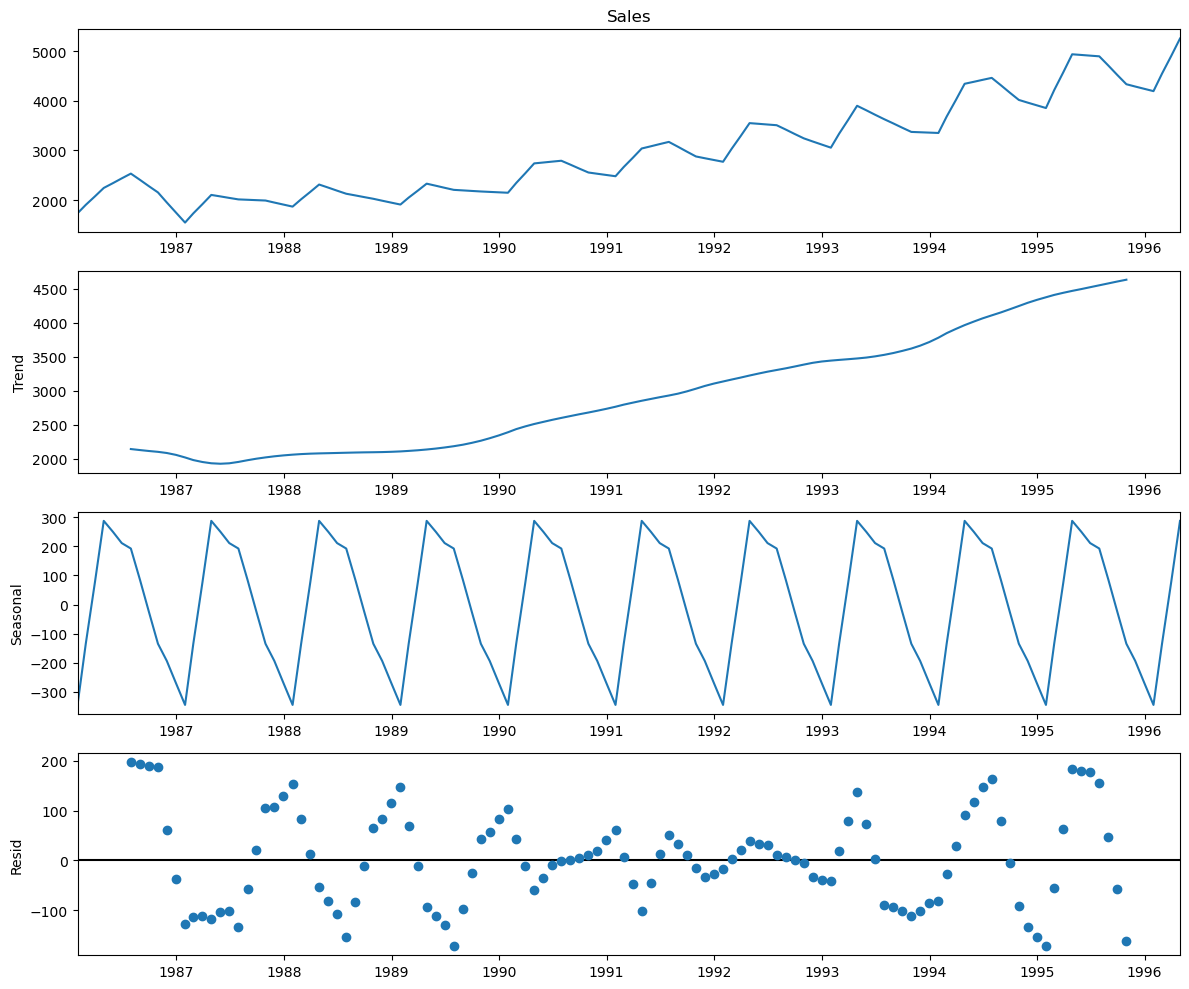

In [22]:
decompose_ts_add = seasonal_decompose(cocacola_upsp.Sales)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

ACF plots and PACF plots

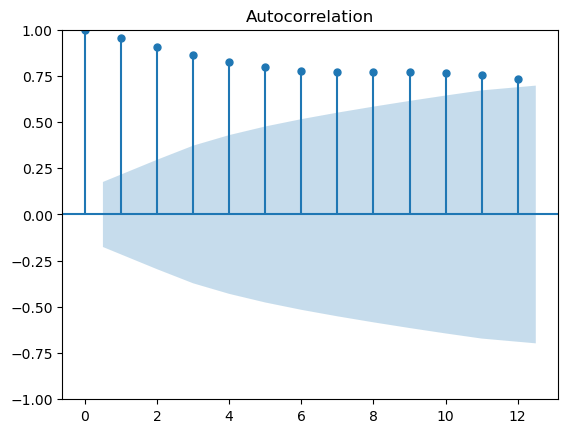

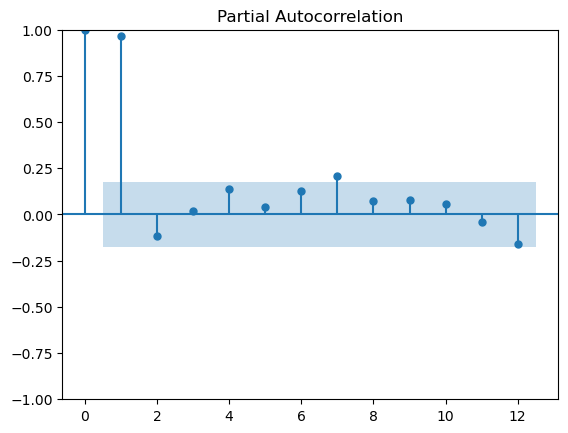

In [23]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(cocacola_upsp.Sales,lags=12)
tsa_plots.plot_pacf(cocacola_upsp.Sales,lags=12)
plt.show()


Splitting data

In [24]:
cocacola_upsp.shape


(124, 18)

In [25]:

Train=cocacola_upsp.head(112)
Test=cocacola_upsp.tail(12)

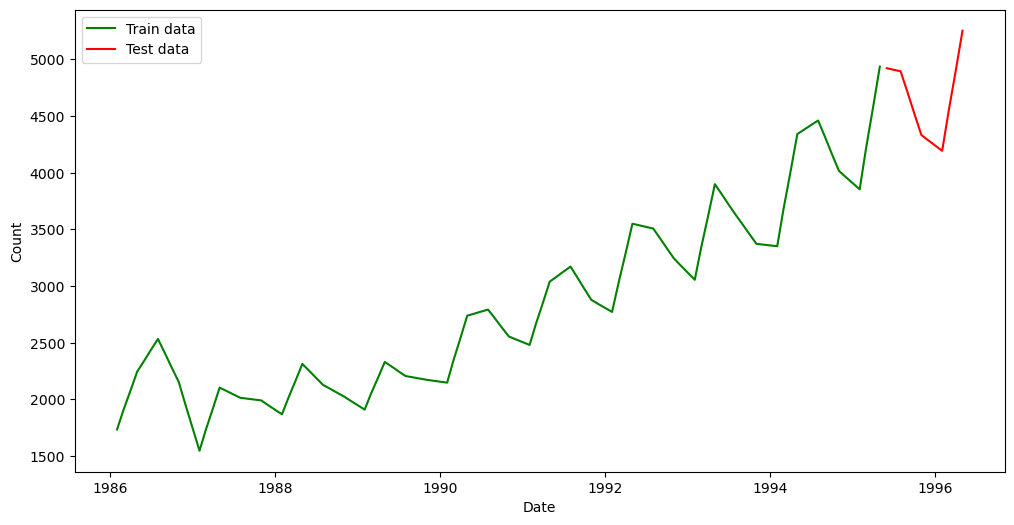

In [26]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(Train.Sales, 'green', label='Train data')
plt.plot(Test.Sales, 'red', label='Test data')
plt.legend()
plt.show()

Forecasting_Data_Driven_Models

Evaluation Metric MAPE

In [27]:

def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

Simple Exponential Method

In [28]:
from sklearn.metrics import mean_squared_error
ses_model = SimpleExpSmoothing(Train['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(12)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,Test.Sales))
train_rmse_ses = np.sqrt(mean_squared_error(train_pred_ses,Train.Sales))
mape_ses = MAPE(test_pred_ses,Test.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 7.816879349714216 
 Train Root Mean Squared Error = 138.77744259150316 
 Test Root Mean Squared Error  = 436.621529823947


C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


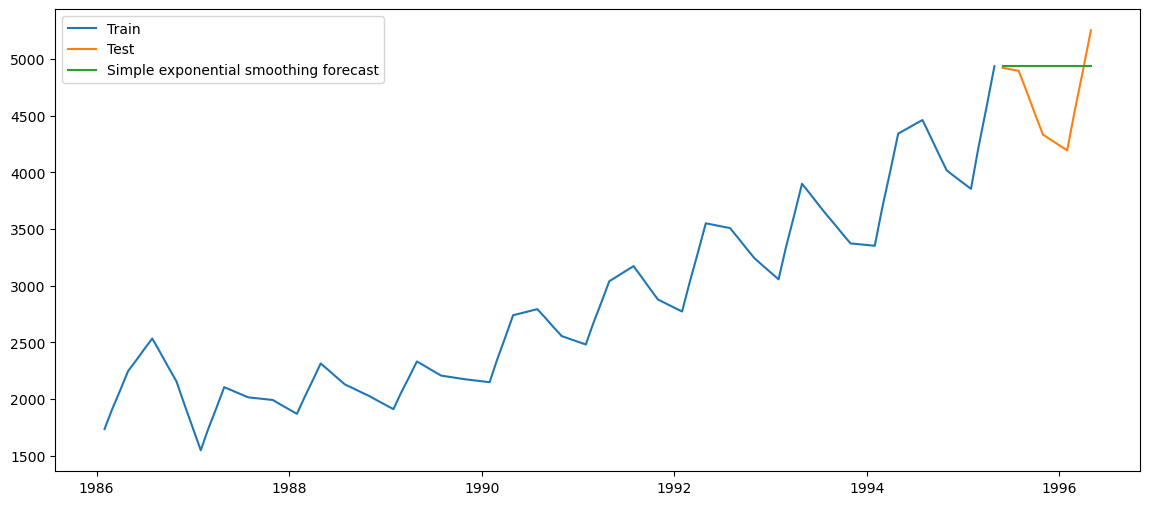

In [29]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.show()


Holt method

In [30]:
hw_model  = Holt(Train["Sales"]).fit(optimized=True)
test_pred_hw = hw_model.forecast(12)
train_pred_hw = hw_model.fittedvalues
test_rmse_hw = np.sqrt(mean_squared_error(test_pred_hw,Test.Sales))
train_rmse_hw = np.sqrt(mean_squared_error(train_pred_hw,Train.Sales))
mape_hw = MAPE(test_rmse_hw,Test.Sales)
print('Holt Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hw),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hw))

Holt Method Evaluation 
 Mean Absolute Percent Error   = 36.237098231794214 
 Train Root Mean Squared Error = 113.61962460976544 
 Test Root Mean Squared Error  = 2945.714856404233


C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


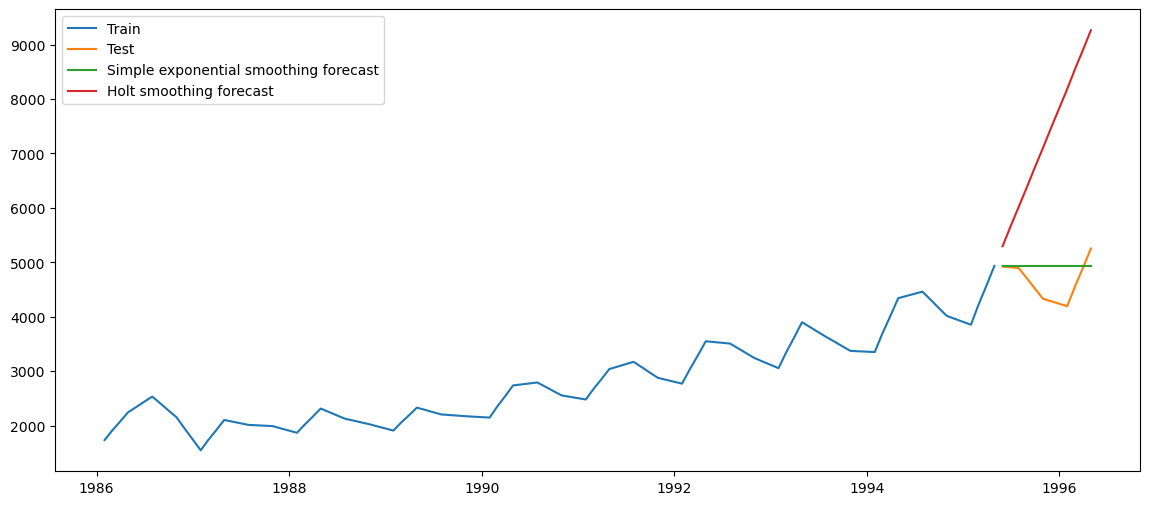

In [31]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.legend(loc='best')
plt.show()


Holts winter exponential smoothing with additive seasonality and additive trend

In [32]:
holts_add_model  = ExponentialSmoothing(Train.Sales,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hltadd = holts_add_model.forecast(12)
train_pred_hltadd= holts_add_model.fittedvalues
test_rmse_hltadd = np.sqrt(mean_squared_error(test_pred_hltadd,Test.Sales))
train_rmse_hltadd = np.sqrt(mean_squared_error(train_pred_hltadd,Train.Sales))
mape_hltadd = MAPE(test_pred_hltadd,Test.Sales)
print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltadd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltadd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltadd))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 24.43908941856226 
 Train Root Mean Squared Error = 46.191854124505326 
 Test Root Mean Squared Error  = 1241.05126932085


C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


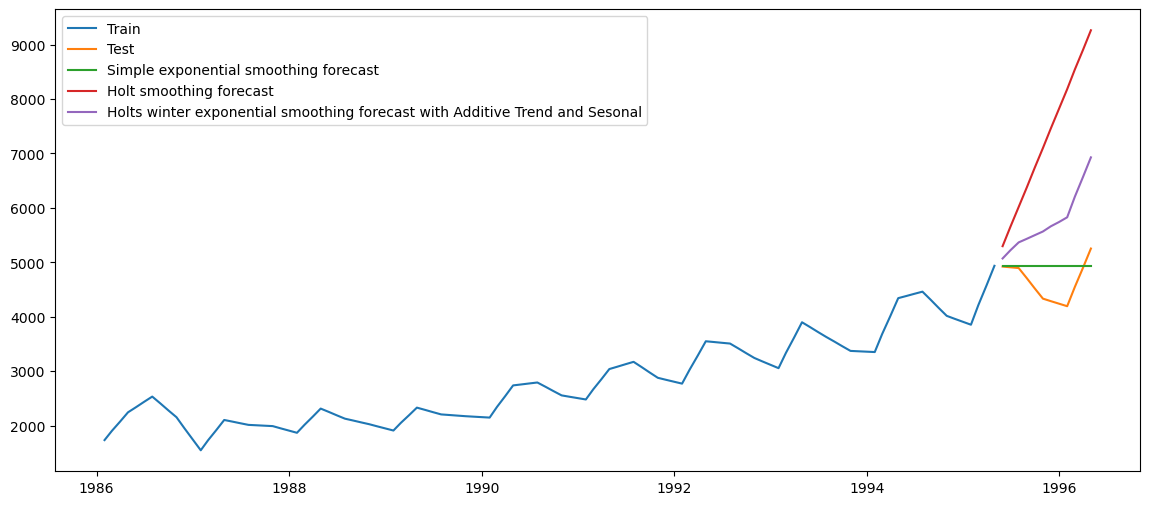

In [33]:

plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with add seasonality and multipicative trend

In [34]:

holts_addmul_model  = ExponentialSmoothing(Train.Sales,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltaddmul = holts_addmul_model.forecast(12)
train_pred_hltaddmul= holts_addmul_model.fittedvalues
test_rmse_hltaddmul = np.sqrt(mean_squared_error(test_pred_hltaddmul,Test.Sales))
train_rmse_hltaddmul = np.sqrt(mean_squared_error(train_pred_hltaddmul,Train.Sales))
mape_hltaddmul = MAPE(test_pred_hltaddmul,Test.Sales)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltaddmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltaddmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltaddmul))

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 6.139692718953332 
 Train Root Mean Squared Error = 189.28194316393734 
 Test Root Mean Squared Error  = 323.78677161282155


C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


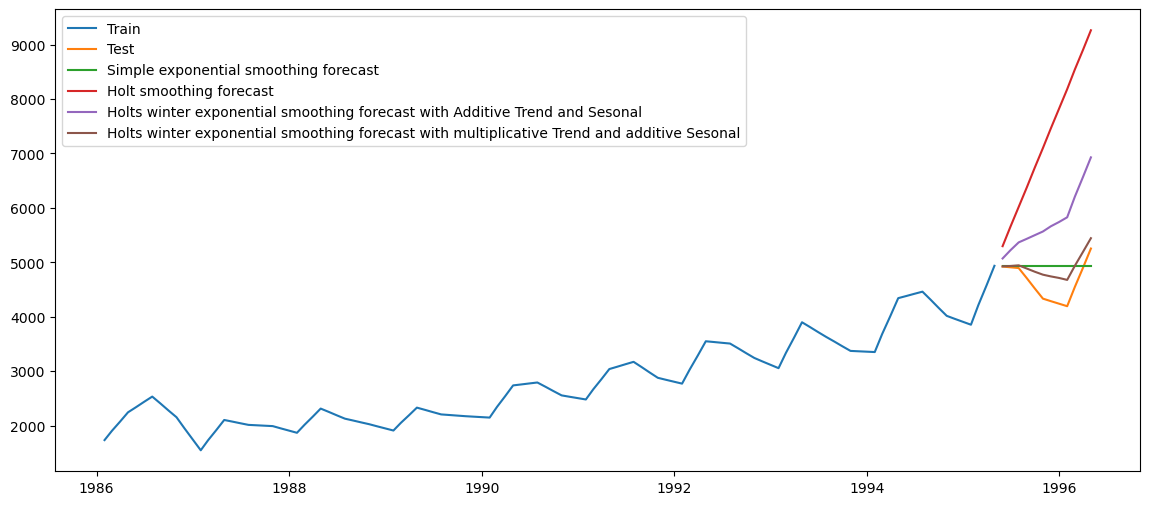

In [35]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.legend(loc='best')
plt.show()


Holts winter exponential smoothing with multiplicative seasonality and multipicative trend

In [36]:
holts_muladd_model  = ExponentialSmoothing(Train.Sales,seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltmuladd = holts_muladd_model.forecast(12)
train_pred_hltmuladd= holts_muladd_model.fittedvalues
test_rmse_hltmuladd = np.sqrt(mean_squared_error(test_pred_hltmuladd,Test.Sales))
train_rmse_hltmuladd = np.sqrt(mean_squared_error(train_pred_hltmuladd,Train.Sales))
mape_hltmuladd = MAPE(test_pred_hltmuladd,Test.Sales)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmuladd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmuladd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmuladd))

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 7.248270720959522 
 Train Root Mean Squared Error = 148.49287995675337 
 Test Root Mean Squared Error  = 346.90388968700756


C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


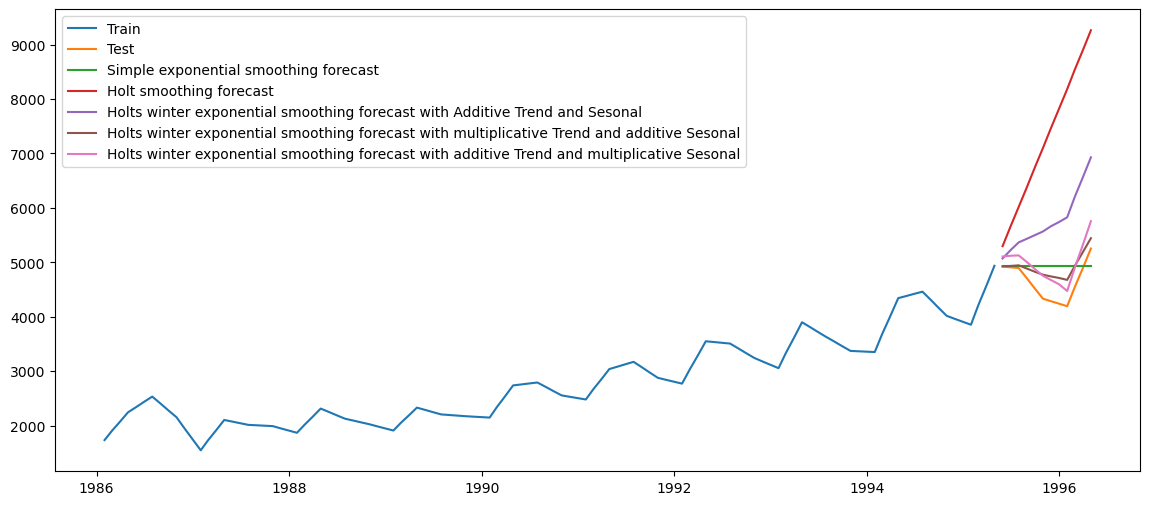

In [37]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

Holts winter exponential smoothing with multiplicative seasonality and multipicative trend

In [38]:
holts_mul_model  = ExponentialSmoothing(Train.Sales,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_hltmul = holts_mul_model.forecast(12)
train_pred_hltmul= holts_mul_model.fittedvalues
test_rmse_hltmul = np.sqrt(mean_squared_error(test_pred_hltmul,Test.Sales))
train_rmse_hltmul = np.sqrt(mean_squared_error(train_pred_hltmul,Train.Sales))
mape_hltmul = MAPE(test_pred_hltmul,Test.Sales)
print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmul))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 1.8799558812584334 
 Train Root Mean Squared Error = 40.94700053430072 
 Test Root Mean Squared Error  = 99.63297346216598


C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


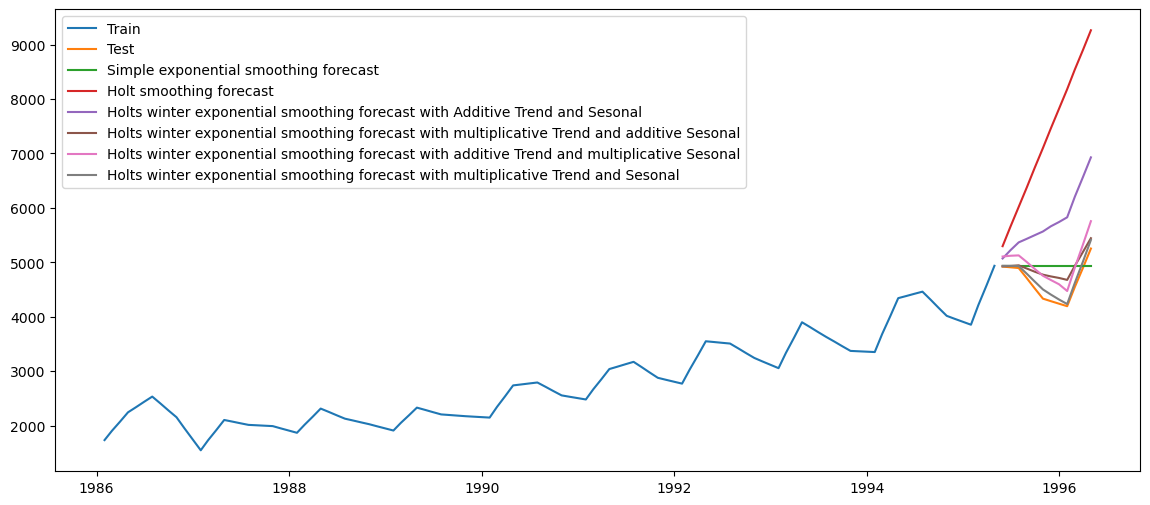

In [39]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.plot(test_pred_hltmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and Sesonal')
plt.legend(loc='best')
plt.show()

All Models results df

In [40]:
all_mw = {"Models":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul"]),
        "Test_MAPE(%)":pd.Series(np.round([mape_ses,mape_hw,mape_hltadd,mape_hltaddmul,mape_hltmuladd,mape_hltmul],2)),
        "Train_RMSE":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul],2)),
        "Test_RMSE_Values":pd.Series(np.round([test_rmse_ses,test_rmse_hw,test_rmse_hltadd,test_rmse_hltaddmul,test_rmse_hltmuladd,test_rmse_hltmul],2))}
table_allmw=pd.DataFrame(all_mw)
table_allmw.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_allmw

,Models,Test_MAPE(%),Train_RMSE,Test_RMSE_Values
0,Holts_Exp_Mul,1.88,40.95,99.63
1,Holts_exp_addmul,6.14,189.28,323.79
2,Holts_exp_muladd,7.25,189.28,346.90
3,Simple_Exp,7.82,138.78,436.62
4,Holts_Exp_Add,24.44,46.19,1241.05
5,holts_exp,36.24,113.62,2945.71


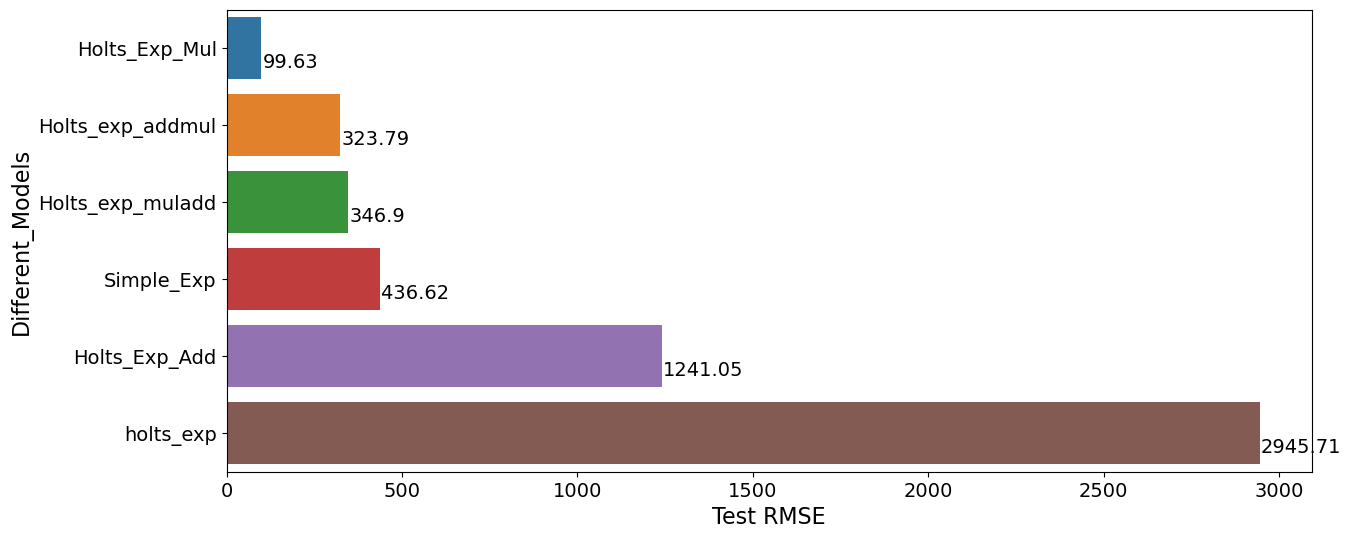

In [41]:
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_allmw, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(table_allmw.Test_RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

Final Model by combining train and test

In [42]:
hwe_model_add_add = ExponentialSmoothing(cocacola_upsp.Sales,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)

C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [43]:
#Forecasting for next 12 time periods
hwe_model_add_add.forecast(12)

1996-05-31    4987.360327
1996-06-30    4943.196104
1996-07-31    4899.054272
1996-08-31    4750.220721
1996-09-30    4607.986128
                 ...     
1996-12-31    4371.618125
1997-01-31    4323.835818
1997-02-28    4614.890507
1997-03-31    4898.567472
1997-04-30    5113.812006
Freq: M, Length: 12, dtype: float64

Forecasting_Model_based_methods

In [44]:

cocacola_upsp

,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
Date,,,,,,,,,,,,,,,,,,
1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223


<Axes: xlabel='year', ylabel='Sales'>

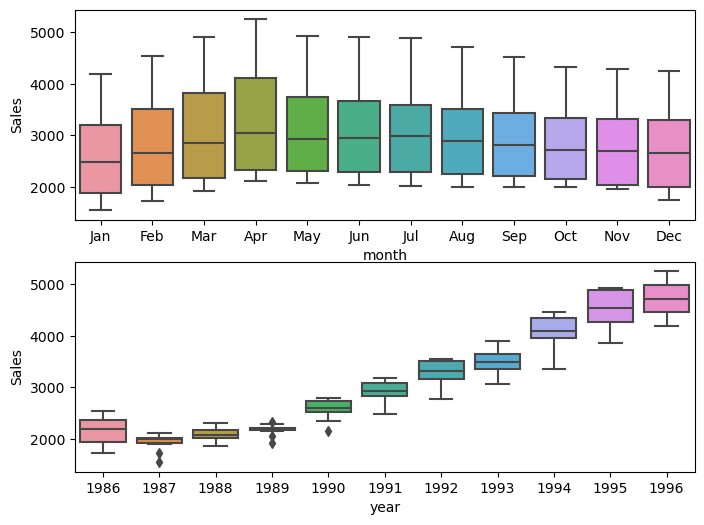

In [45]:
# box plot for ever
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x='month',y='Sales',data=cocacola_upsp)
plt.subplot(212)
sns.boxplot(x='year',y='Sales',data=cocacola_upsp)

<Axes: xlabel='year', ylabel='Sales'>

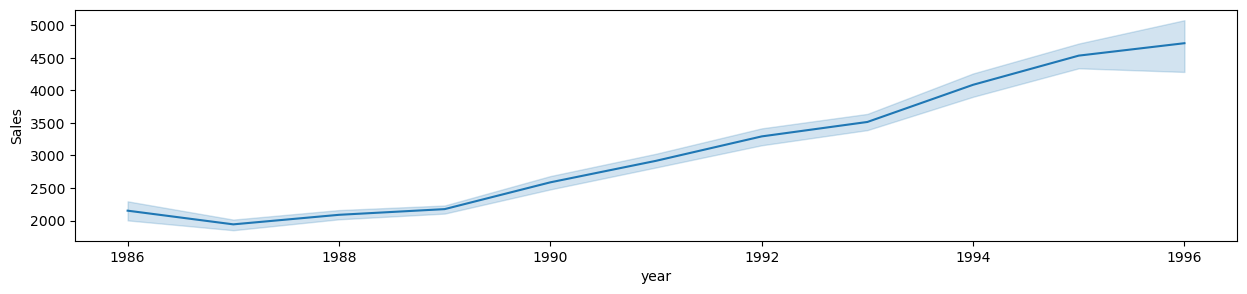

In [46]:
plt.figure(figsize=(15,3))
sns.lineplot(x='year',y='Sales',data=cocacola_upsp)

In [47]:
Train=cocacola_upsp.head(112)
Test=cocacola_upsp.tail(12)
Test

,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
Date,,,,,,,,,,,,,,,,,,
1995-05-31,4922.333333,113,12769,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,8.501538
1995-06-30,4908.666667,114,12996,Jun,1995,0,0,0,0,0,1,0,0,0,0,0,0,8.498758
1995-07-31,4895.000000,115,13225,Jul,1995,0,0,0,0,0,0,1,0,0,0,0,0,8.495970
1995-08-31,4707.666667,116,13456,Aug,1995,0,0,0,0,0,0,0,1,0,0,0,0,8.456948
1995-09-30,4520.333333,117,13689,Sep,1995,0,0,0,0,0,0,0,0,1,0,0,0,8.416341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223



i)Linear model

In [48]:
import statsmodels.formula.api as smf
linear_model=smf.ols('Sales~t',data=Train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rsme_linear=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rsme_linear

561.9428078334428

ii)Exponential Model

In [49]:
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

432.8783117870584


iii)Quadratic Model

In [50]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

416.1240473625366


iv)Additive seasonality

In [51]:
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1840.3042900245862


v)Additive Seasonality Quadratic

In [52]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

271.90623331298764


vi)Multiplicative Seasonality

In [53]:
Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1939.0823781993154


vii)Multiplicative Additive Seasonality

In [54]:

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

236.26364020374857

Compare the results

In [55]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series(np.round([rsme_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea],2))}
table_rmse=pd.DataFrame(data)
table_rmse=table_rmse.sort_values(['RMSE_Values'])
table_rmse

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,236.26
4,rmse_add_sea_quad,271.91
2,rmse_Quad,416.12
1,rmse_Exp,432.88
0,rmse_linear,561.94
3,rmse_add_sea,1840.30
5,rmse_Mult_sea,1939.08


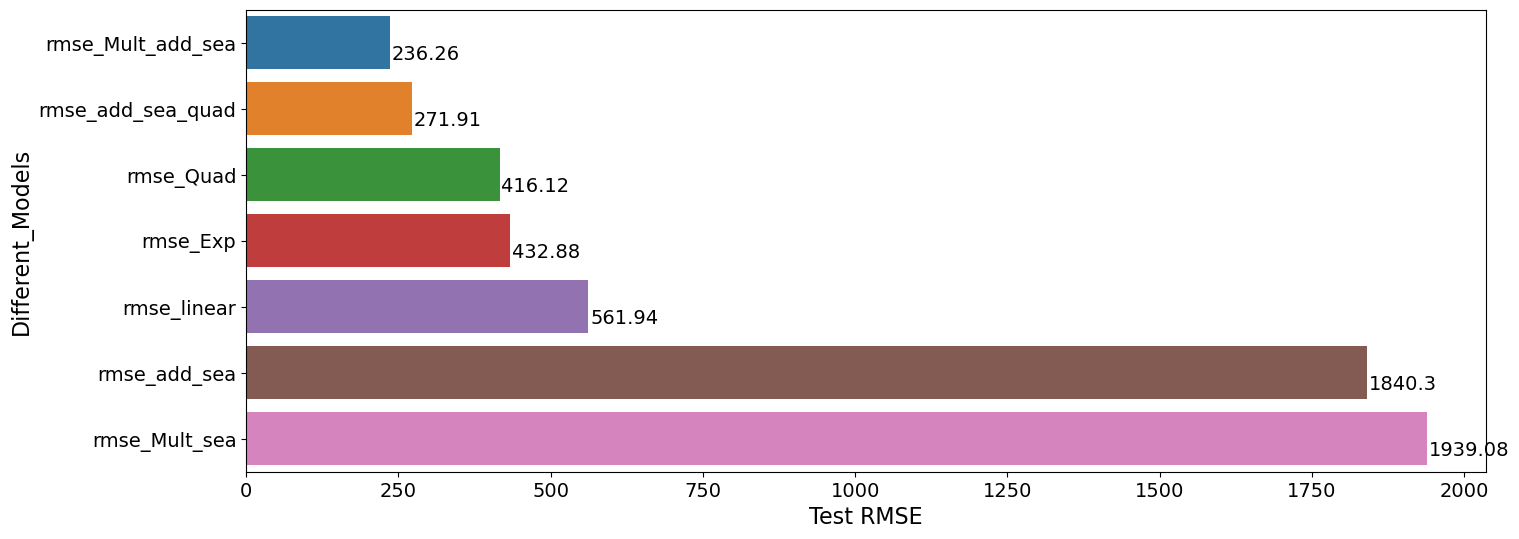

In [56]:
f, axe = plt.subplots(1,1, figsize=(16,6))
sns.barplot(x='RMSE_Values', y='MODEL', data=table_rmse, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(table_rmse.RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

ARIMA Hyperparameters

In [57]:

# walk-forward validation
history = [x for x in Train.Sales]
predictions = []
for i in range(len(Test.Sales)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = Test.Sales[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = np.sqrt(mean_squared_error(Test.Sales, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=4936.000, Expected=4922.333
>Predicted=4922.333, Expected=4908.667
>Predicted=4908.667, Expected=4895.000
>Predicted=4895.000, Expected=4707.667
>Predicted=4707.667, Expected=4520.333
>Predicted=4520.333, Expected=4333.000
>Predicted=4333.000, Expected=4286.667
>Predicted=4286.667, Expected=4240.333
>Predicted=4240.333, Expected=4194.000
>Predicted=4194.000, Expected=4547.000
>Predicted=4547.000, Expected=4900.000
>Predicted=4900.000, Expected=5253.000
RMSE: 201.269


In [61]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [62]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                  rmse = evaluate_arima_model(Test.Sales, order)
                  if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


Build Model based on the optimized values

C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\deshp\anaconda33\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  112
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -642.589
Date:                Thu, 22 Feb 2024   AIC                           1301.177
Time:                        00:22:41   BIC                           1322.854
Sample:                    01-31-1986   HQIC                          1309.971
                         - 04-30-1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6464      0.496      1.302      0.193      -0.327       1.619
ar.L2          0.1167      0.383      0.305      0.760      -0.634       0.867
ar.L3         -0.1851      0.228     -0.811      0.4

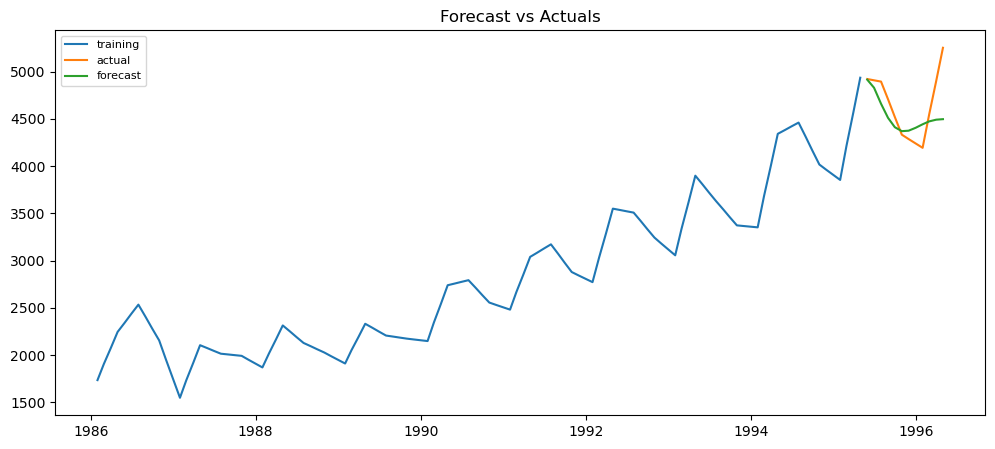

In [69]:
# Build Model
model = ARIMA(Train.Sales, order=(4, 1, 3))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Train.Sales, label='training')
plt.plot(Test.Sales, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [70]:
Arima_rmse = np.mean((fc - Test.Sales)**2)**.5
Arima_rmse

281.88858734753506

Conclusion:

In [72]:
pd.reset_option('display.max_rows')
all_rsme={"MODEL":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul","rmse_linear",
                             "rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea","ARIMA"]),
        "RMSE_Values":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul,
                                          rsme_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea,Arima_rmse],2))}
tab_rmse=pd.DataFrame(all_rsme)
tab_rmse=tab_rmse.sort_values(['RMSE_Values'])
tab_rmse

,MODEL,RMSE_Values
5,Holts_Exp_Mul,40.95
2,Holts_Exp_Add,46.19
1,holts_exp,113.62
0,Simple_Exp,138.78
3,Holts_exp_addmul,189.28
4,Holts_exp_muladd,189.28
12,rmse_Mult_add_sea,236.26
10,rmse_add_sea_quad,271.91
13,ARIMA,281.89
8,rmse_Quad,416.12


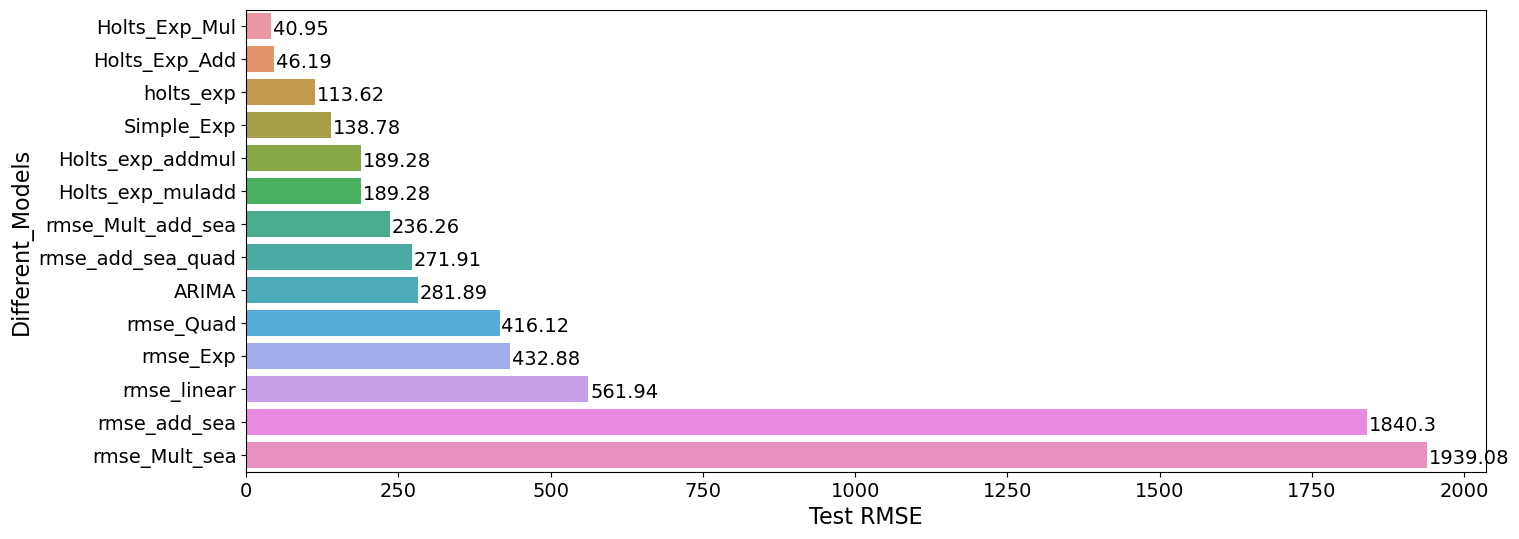

In [73]:

f, axe = plt.subplots(1,1, figsize=(16,6))
sns.barplot(x='RMSE_Values', y='MODEL', data=tab_rmse, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(tab_rmse.RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

Holts_exp_mul and Holts_exp_add are giving least RMSE out of all the models, and these will be useful for forecasting.